Implements a random forest classifier to classify Alzheimer's disease, with steps including:
- Applying Principal Component Analysis (PCA) for dimensionality reduction and feature extraction
- Cross-validation of classification results
- Permutation testing for statistical significance using parallel processing.
- Exploring feature importance

In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from scipy.stats import false_discovery_control
import dask.array as da
import mlflow
mlflow.autolog(disable=True)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import time
from IPython.display import clear_output

import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from random_forest import RF, classification_RF_shuffle, iteration_permute, iteration_PCs, iteration_permute_PCs
from visualize import multiclass_summary
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed_xfold.pkl'
data_xfold=load_pickle_s3(bucket_name, s3_file_name, dbutils)

data=data_xfold['data']
labels=np.array(data_xfold['labels'])

train_idx_fold=data_xfold['train_idx_fold']
test_idx_fold=data_xfold['test_idx_fold']

class_lab = ['Mild', 'Moderate', 'None', 'Very Mild']

Decompose data with PCA

In [0]:
data_pca = []
for i in range(len(data)):
    data_pca.append(np.reshape(data[i], (1, -1)))    
data_pca = np.vstack(data_pca[:])

# decompose with PCA and look at various metrics/info
num_comp = 50
pca = PCA(n_components = num_comp)
pca.fit(data_pca)
clear_output(wait=False)

Visualize variance explained and 2D PC representation of dataset

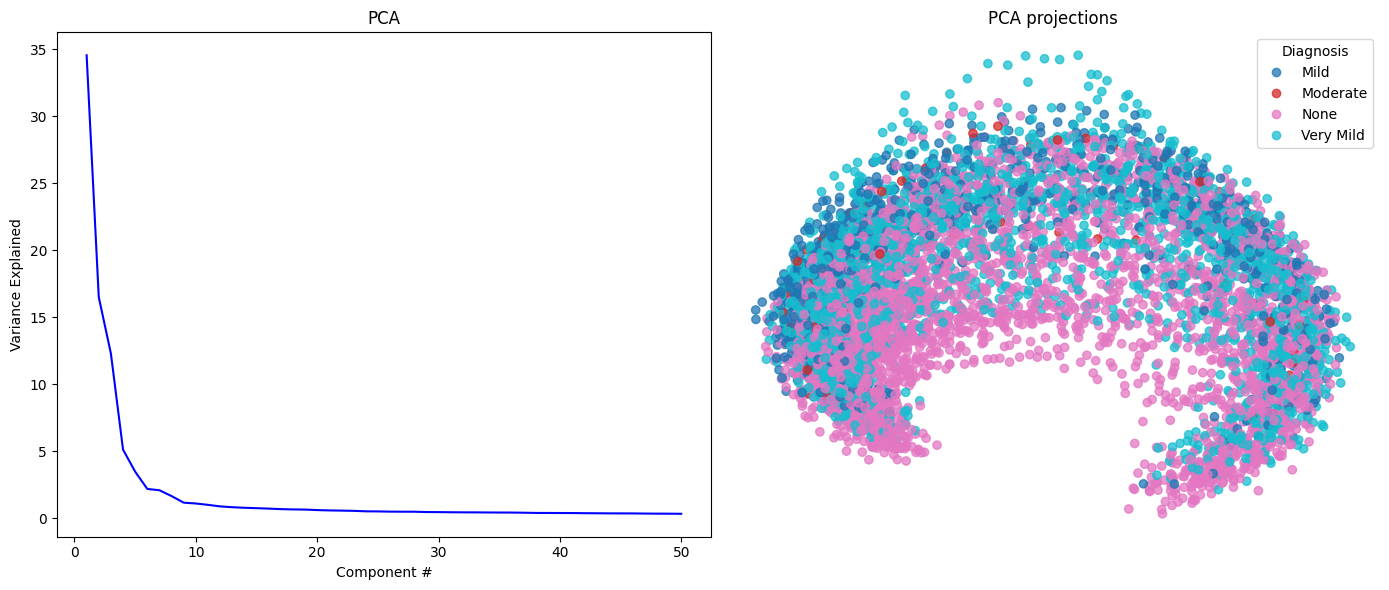

In [0]:
# project data on first two PC's
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_tot = np.matmul(data_pca, loadings[:,:2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot variance explained
ax1.plot(np.linspace(1, num_comp, num_comp), pca.explained_variance_[:num_comp]/sum(pca.explained_variance_[:num_comp]) * 100, 'b')
ax1.set_title('PCA')
ax1.set_xlabel('Component #')
ax1.set_ylabel('Variance Explained')

# Plot first two PCs
s = ax2.scatter(load_tot[:, 0], load_tot[:, 1], c=labels * 2, cmap='tab10', alpha=0.75)
handles, labels = s.legend_elements()
legend = ax2.legend(handles=handles, labels=Lab, title='Diagnosis', loc='upper right')
ax2.axis('off')
ax2.set_title('PCA projections')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

Apply random forest classifier to first two PCs (5-fold cross validation)

In [0]:

# Perform X-fold cross validation
data_load = np.matmul(data_pca, loadings[:,:2])

predictions_fold = []
true_labels_fold = []
for i in range(len(train_idx_fold)):
    train_data = data_load[train_idx_fold[i],:]
    train_labels = labels[train_idx_fold[i]]
    test_data = data_load[test_idx_fold[i],:]
    test_labels = labels[test_idx_fold[i]]
    predictions, true_labels = RF(train_data, train_labels, test_data, test_labels)
    
    predictions_fold.append(predictions)
    true_labels_fold.append(true_labels)

clear_output(wait=False)

Summarize results

Classification accuracy for fold 1 = 48.91 %
Classification accuracy for fold 2 = 47.81 %
Classification accuracy for fold 3 = 48.20 %
Classification accuracy for fold 4 = 48.59 %
Classification accuracy for fold 5 = 50.47 %

Overall classification accuracy is: 48.80 %



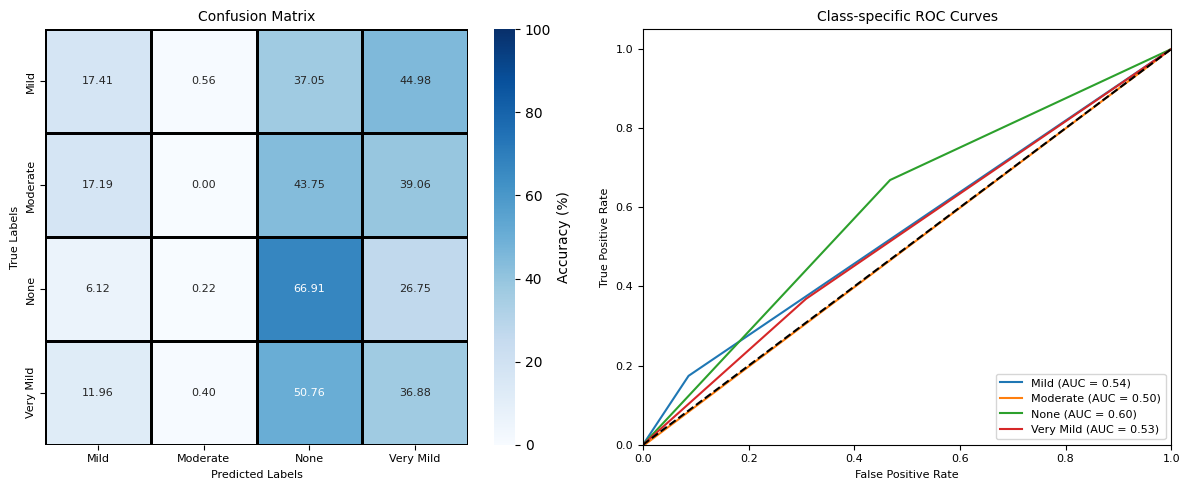

Mild - Precision: 0.25, Recall: 0.17, F1 Score: 0.20
Moderate - Precision: 0.00, Recall: 0.00, F1 Score: 0.00
None - Precision: 0.59, Recall: 0.67, F1 Score: 0.63
Very Mild - Precision: 0.39, Recall: 0.37, F1 Score: 0.38

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_2PC_acc.pkl


In [0]:
# Compare predictions with test labels and compute accuracy
acc_fold = []
for fold in range(len(predictions_fold)):
    result = predictions_fold[fold] - true_labels_fold[fold]
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary, 0)
    acc_fold.append(correct / true_labels_fold[fold].shape[0] * 100)
    print(f"Classification accuracy for fold {fold+1} = {acc_fold[fold]:.2f} %")

print()
print(f"Overall classification accuracy is: {np.mean(acc_fold):.2f} %")
print()

# Visualize summary of predictions
multiclass_summary(np.concatenate(predictions_fold, axis=0), np.concatenate(true_labels_fold, axis=0), class_lab)
print()

# Save results
results = {
    "predictions": predictions_fold,
    "true_labels": true_labels_fold,
    "accuracy": acc_fold
}
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_2PC_acc.pkl'
save_pickle_s3(results, bucket_name, s3_file_path, dbutils)

When using the top two PCs, we see a modest classification rate on the test set. However, there is a clear bias here towards the Moderate AD class, which had the largest bias in the training dataset.

Furthermore, using two PC's  is arbitrary and is easy simply due to visualization purposes. We can also examine accuracy as a function of the number of PCs, and visualize the PC loading maps to interpret the classification results. But first, let's run some statistics to determine if the classification is significant in its current state.

We perform statistical testing to determine if the classification is significantly different (above) chance level. Here, we will do this using permutation testing where we randomly shuffle the training labels before building the classifier and then obtain accuracy values with the original testing labels. By randomly shuffling the training labels hundreds of times, we can build a null distribution and then observe where the "true" classification rate falls.

Since we will be doing a lot of iterations, let's first validate that parallel processing reducs computation time compared to serial processing

In [0]:
# Prepare data for dask parallelization tasks
data_pca_da = da.from_array(data_pca, chunks=(1000, data_pca.shape[1]))
loadings_da = da.from_array(loadings, chunks=(loadings.shape[0], 10))

In [0]:
# Data set for testing parallelization (just one fold)
data_pca_dask = np.matmul(data_pca_da, loadings_da[:,:2])
load_train = data_load[train_idx_fold[0],:]
train_labels = labels[train_idx_fold[0]]
load_test = data_load[test_idx_fold[0],:]
test_labels = labels[test_idx_fold[0]]

# Serial for loop
start_time = time.time()
acc_shuffle_nodask = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_labels, load_test, test_labels)
    acc_shuffle_nodask.append(acc_tmp)
end_time = time.time()
total_time = end_time - start_time

# Parallel for loop (dask)
start_time1 = time.time()
acc_shuffle_dask = iteration_permute(load_train, train_labels, load_test, test_labels, n_iterations=100)   
end_time1 = time.time()
total_time1 = end_time1 - start_time1

clear_output(wait=False)
display(f"Serial For Loop: {total_time:.2f} seconds")
display(f"Parallel For Loop: {total_time1:.2f} seconds")

Serial For Loop: 172.91656708717346 seconds
Parallel For Loop: 151.82922959327698 seconds


We can see that parallelization with dask markedly reduces the computation time (CPU) by ~12% when performing 100 iterations.

Total time elapsed: 780.5284969806671 seconds

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_2PC_acc_permute.pkl


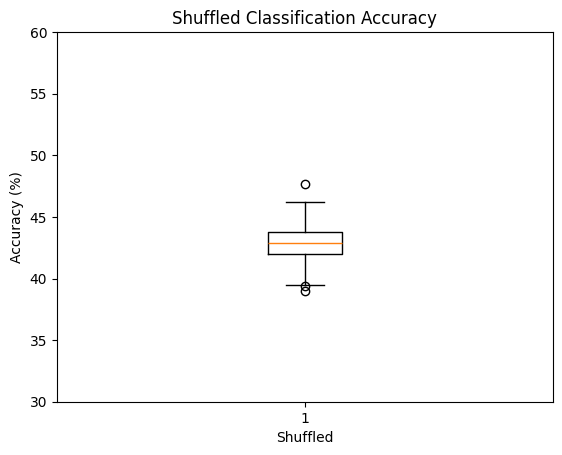

In [0]:
# Permute 100 times per fold for an even distribution
start_time = time.time()

data_pca_dask = np.matmul(data_pca_da, loadings_da[:,:2])
acc_permute_fold = []
for num_fold in range(len(train_idx_fold)):
    
    # Extract data per fold
    load_train = data_load[train_idx_fold[num_fold],:]
    train_labels = labels[train_idx_fold[num_fold]]
    load_test = data_load[test_idx_fold[num_fold],:]
    test_labels = labels[test_idx_fold[num_fold]]

    acc_permute = []
    for i in range(2):
        acc_tmp=iteration_permute(load_train, train_labels, load_test, test_labels, n_iterations=50)
        acc_permute = np.concatenate((acc_permute, acc_tmp), axis=0)

    acc_permute_fold.append(acc_permute)

acc_permute_tot = np.concatenate(acc_permute_fold, axis=0)

b = plt.boxplot(acc_permute_tot)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time elapsed: {total_time:.2f} seconds")
print()

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_2PC_acc_permute.pkl'
save_pickle_s3(acc_permute_tot, bucket_name, s3_file_path, dbutils)

Determine significance of classification accuracy (permutation test)

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"

s3_file_path='AD_MRI_classification/results/RF_2PC_acc.pkl'
results=load_pickle_s3(bucket_name, s3_file_path, dbutils)

s3_file_path='AD_MRI_classification/results/RF_2PC_acc_permute.pkl'
acc_permute_tot=load_pickle_s3(bucket_name, s3_file_path, dbutils)

# Permutation p-value derivation
accuracy = np.array(results['accuracy'])
null_above_value = (acc_permute_tot > accuracy.mean()).sum()
p_value = null_above_value/np.size(acc_permute_tot,0)
display(f"The p-value for the classification accuracy of {accuracy.mean():.2f}% is {p_value}")

'The p-value for the classification accuracy of 48.80% is 0.0'

Now explore RF classification as a function of PCs

In [0]:

start_time = time.time()

num_pc=np.linspace(1,50,50, dtype = 'int')

acc_pc_tot = []
for num_fold in range(len(train_idx_fold)):

    # Extract data per fold
    train_data = data_pca[train_idx_fold[num_fold],:]
    train_labels = labels[train_idx_fold[num_fold]]
    test_data = data_pca[test_idx_fold[num_fold],:]
    test_labels = labels[test_idx_fold[num_fold]]

    acc_pc=iteration_PCs(train_data, train_labels, test_data, test_labels, loadings_da, num_pc)
    acc_pc_tot.append(acc_pc)

acc_pc_tot = np.vstack(acc_pc_tot)

clear_output(wait=False)
end_time = time.time()
total_time = end_time - start_time
print(f"Total time elapsed: {total_time:.2f} seconds")
print()

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
save_pickle_s3(acc_pc_tot, bucket_name, s3_file_path, dbutils)

Total time elapsed: 1118.3439741134644 seconds

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/RF_NUM_PCS_acc.pkl


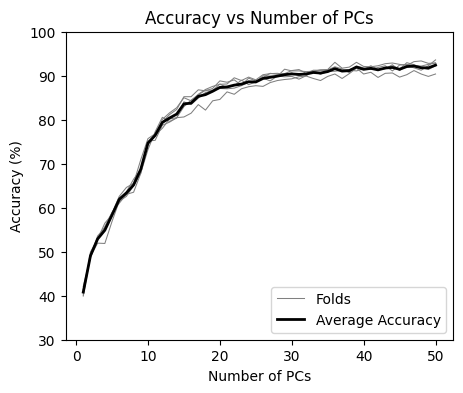

In [0]:
# Load results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc.pkl'
acc_pc_tot=load_pickle_s3(bucket_name, s3_file_path, dbutils)

# Plot accuracy as a function of number of PCs
plt.figure(figsize=(5, 4))

for num_fold in range(len(acc_pc_tot)):
    plt.plot(num_pc, acc_pc_tot[num_fold], 'gray', linewidth=0.75, label=f'Folds' if num_fold == 0 else "")

plt.plot(num_pc, acc_pc_tot.mean(axis=0), 'k', linewidth=2, label='Average Accuracy')

plt.xlabel('Number of PCs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of PCs')
plt.ylim(30, 100)
plt.legend()
plt.show()

## Permutation testing for each number of PCs

In [0]:
# Permute 100 times per fold, per PC 
start_time = time.time()

num_pc = np.linspace(2, 50, 25, dtype='int')

acc_pc_permute_tot = []
for num_pc in num_pc:  # PC

    acc_pc_permute_pc = np.array([])
    for num_fold in range(len(train_idx_fold)): # Fold
        
        train_data = data_pca[train_idx_fold[num_fold],:]
        train_labels = labels[train_idx_fold[num_fold]]
        test_data = data_pca[test_idx_fold[num_fold],:]
        test_labels = labels[test_idx_fold[num_fold]]

        acc_pc_permute_fold = np.array([])
        for i in range(2):  # Iteration within pc
            acc_tmp = iteration_permute_PCs(train_data, train_labels, test_data, test_labels, loadings_da, num_pc, n_iterations=50)
            acc_pc_permute_fold=np.concatenate((acc_pc_permute_fold, acc_tmp), axis=0)

        acc_pc_permute_pc=np.concatenate((acc_pc_permute_pc, acc_pc_permute_fold), axis=0)

    acc_pc_permute_tot.append(acc_pc_permute_pc)

acc_pc_permute_tot = np.vstack(acc_pc_permute_tot)

end_time = time.time()
total_time = end_time - start_time
print(f"Total time: {total_time:.2f} seconds")
print()

# Save results
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/RF_NUM_PCS_acc_permute.pkl'
save_pickle_s3(acc_pc_permute_tot, bucket_name, s3_file_path, dbutils)

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38301 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35189
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:38301/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33077'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35809'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38505 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38505
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43786
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34399 name: 0
INFO:distributed.scheduler:Starting worke

Compare classification accuracy to chance level for each PC step

In [0]:
# plot accuracy as a function of PCs

# accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(acc_PC_compile,0), np.size(acc_PC_compile,0)), acc_PC_compile, 'k')

# corresponding chance level
p_value_compile = []
for i in range(len(acc_shuffle_PC_compile)):
    b = plt.boxplot(acc_shuffle_PC_compile[i], 'b', positions = [i+1], flierprops = {'marker': '.', 'markersize': 5})

    # permutation testing
    null_above_value = (acc_shuffle_PC_compile[i] > acc_PC_compile[i]).sum()
    p_value_compile.append(null_above_value/np.size(acc_shuffle_PC_compile[i],0))

# visualize statistical results
p_value_compile = np.array([float(num) for num in p_value_compile])
p_value_adj = false_discovery_control(p_value_compile)   

for i in range(len(p_value_adj)): 
    if p_value_adj[i] < 0.05:
        plt.scatter(i, 95, s = 10, c = 'r', marker = "*")

plt.title('Classification accuracy')
plt.xlabel('# of PCs included')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 100)
plt.xlim(-5, 105)
p_value_compile

## Feature interpretation

### Visualize spatial PC maps to identify features that contribute to data variance and classification

In [0]:
f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()

#### Here we can see that for each of the top 20 PC's there are brain regions are more strongly weighted than others (in either the positive or negative direction). It is important to note that it does not appear that each image used in this dataset came from the same location/slice within the brain. We do not know if certain slices are over- or under-represented in different AD classes and therefore cannot say with certainty whether specific anatomical structures drive different stages of AD. Nevertheless,